# Classification

There are 2 differences between classification and regression:
* you always predict a probability
* the target variable is restricted to the [0,1] interval
* the sample may be extremely imbalanced
* the business case is usually very important, false positives and false negatives are rarely the same

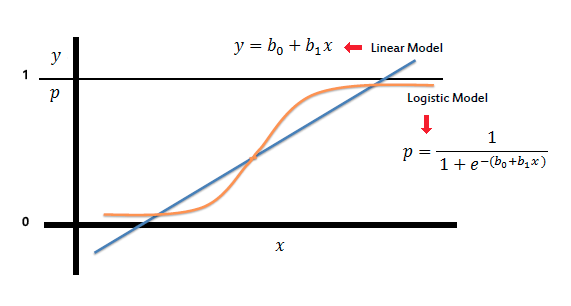

In [31]:
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
import re


# SVM


## Basics
* Maximal Margin Classifier
* Support Vector Classifier
* Support Vector Machines
* Kernel Trick



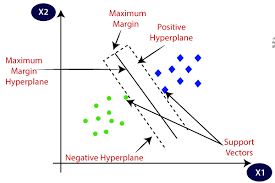

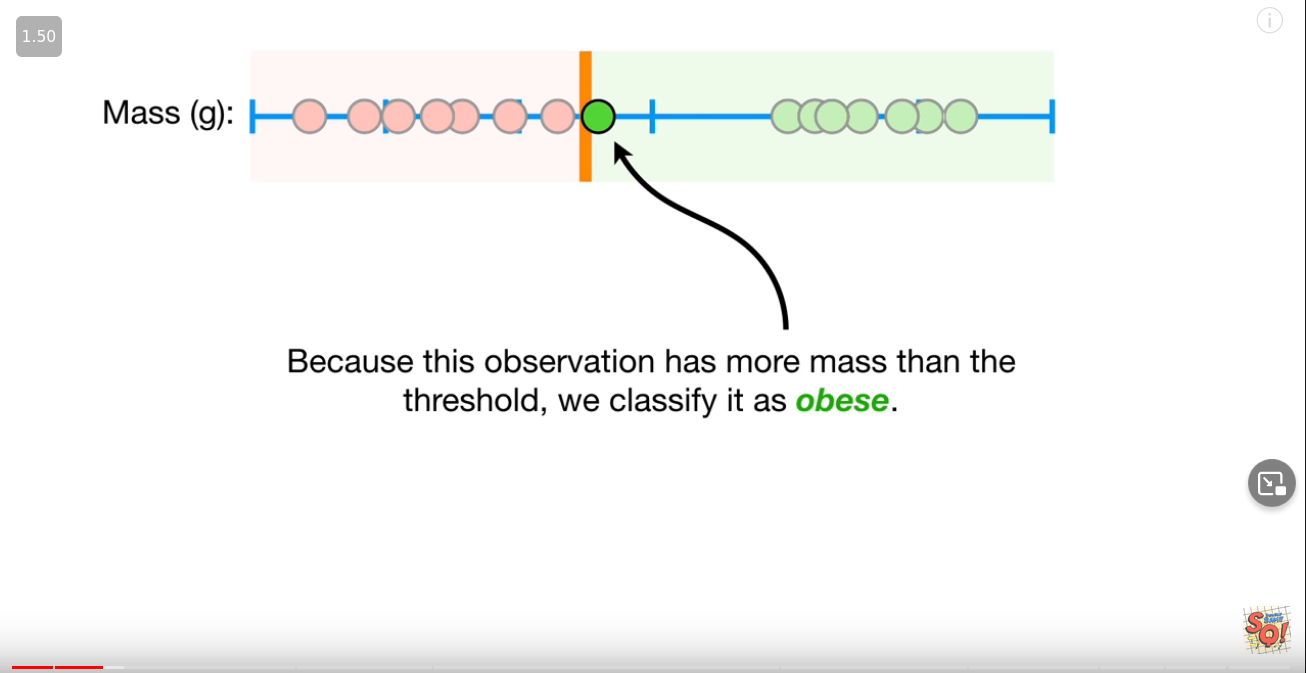


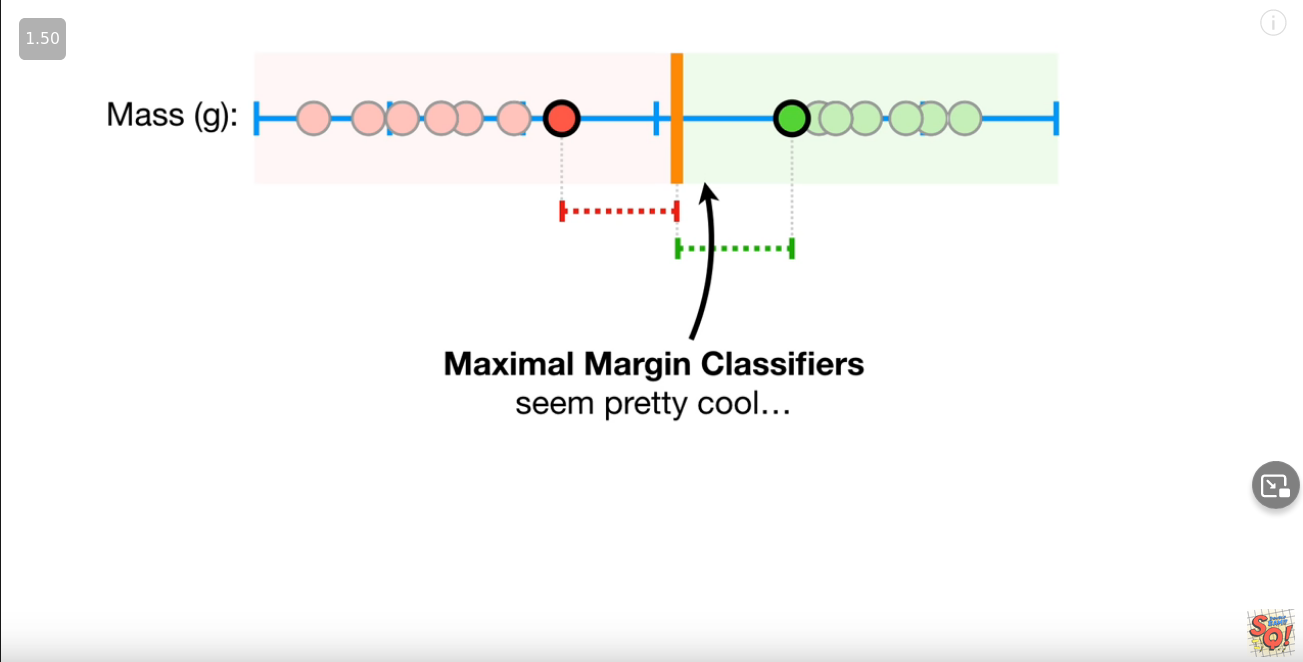

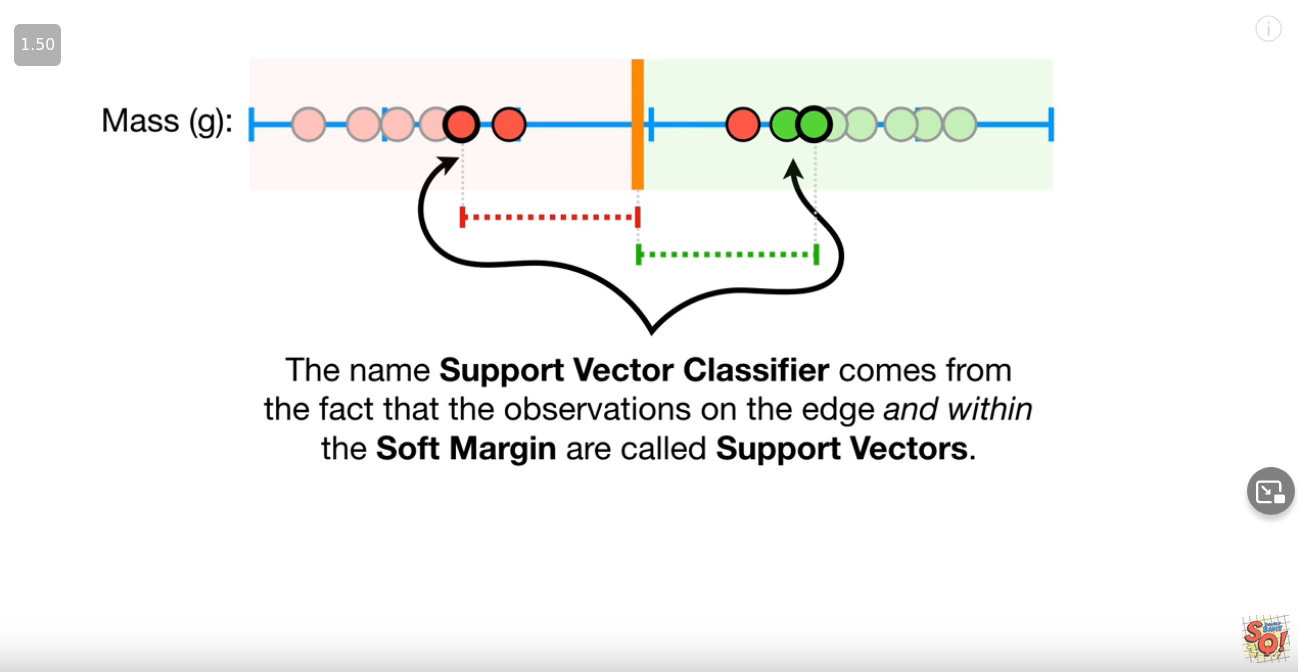

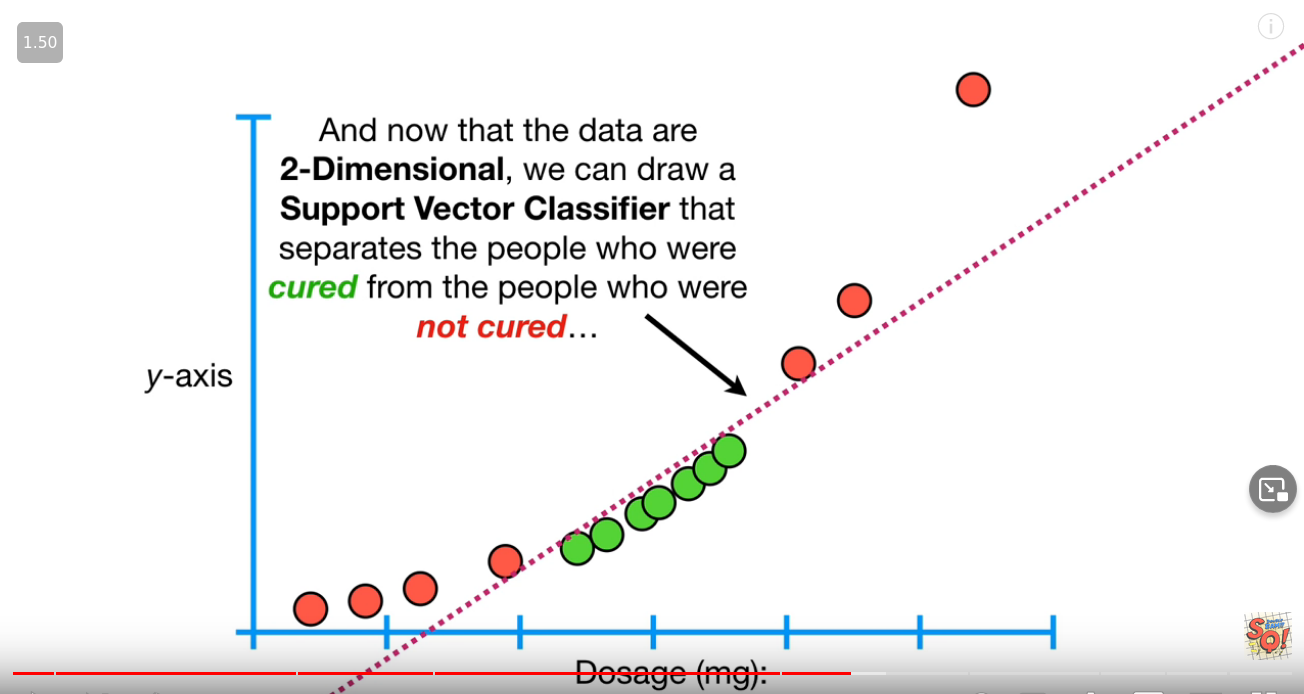

# Our Analysis Tool: Confusion Matrix

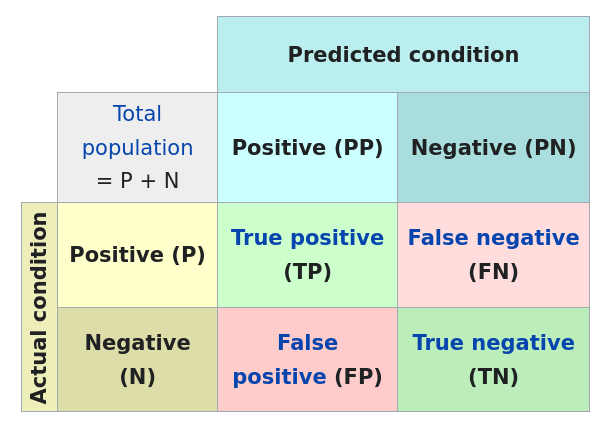

# Our most important Metrics:
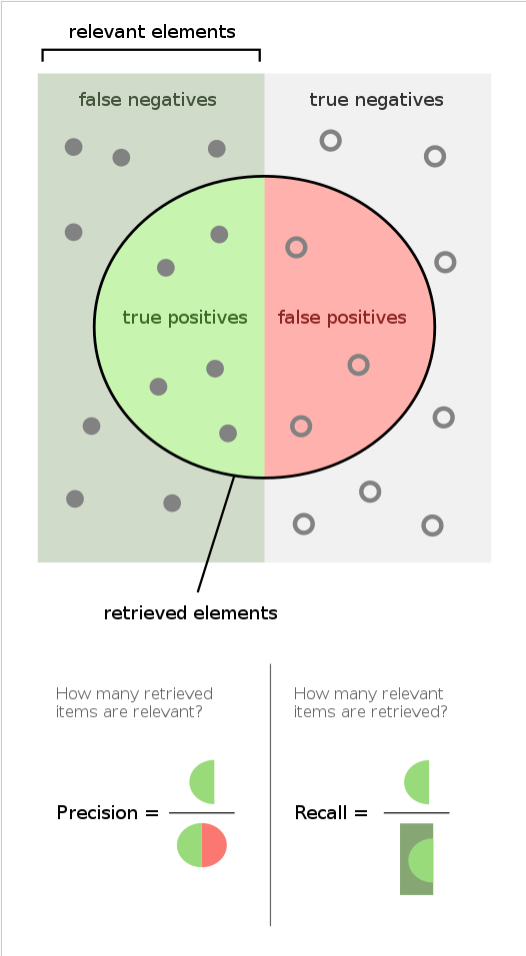

# Precision - Recall vs ROC-AUC
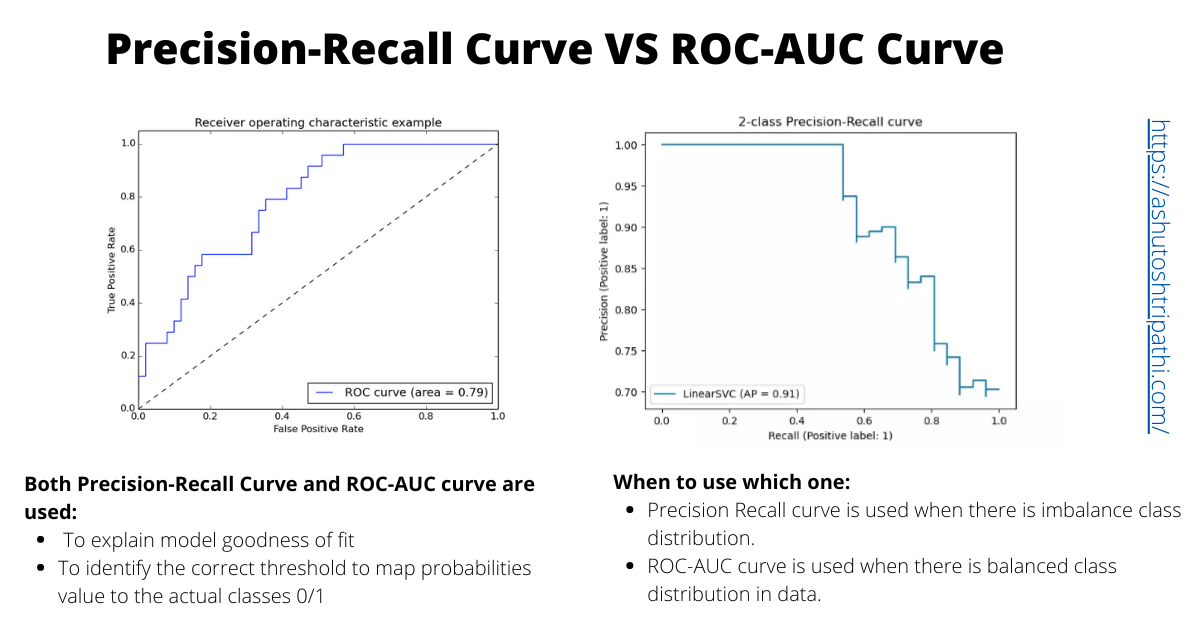

In [73]:
import numpy as np
train_data = pd.read_csv("aug_train.csv", index_col="enrollee_id").assign(
    experience_float=lambda df: df["experience"]
    .fillna("0")
    .apply(lambda exp: int("".join(re.findall("\d+", exp)))),
    last_new_job_float=lambda df: np.where(df['last_new_job']!='never',
                                          df['last_new_job'].fillna('0').replace({"never":100}).astype(str).\
                                            apply(lambda x: int("".join(re.findall('\d+',x)))),
                                           df['experience_float']),
    gender_float=lambda df: (df['gender']=='Male').astype(int)
)

In [74]:
train_data.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,experience_float,last_new_job_float,gender_float
enrollee_id,,,,,,,,,,,,,,,,
8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0,20,1,1
29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0,15,4,1
11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0,5,5,0
33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0,1,1,0
666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0,20,4,1


In [166]:
for col in ['city','enrolled_university','education_level','major_discipline','relevent_experience']:
    te=TargetEncoder(min_samples_leaf=10, smoothing=0.5)
    train_data[f'{col}_encoded']=te.fit_transform(train_data[col],train_data['target'])


In [167]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

target_encoding_features = [
    "city",
    "enrolled_university",
    "education_level",
    "major_discipline",
]
other_features = [
    "city_development_index",
    "gender_float",
    "training_hours",
    "experience_float",
    "last_new_job_float",
]
te_pipeline = Pipeline(
    steps=[
        ("encoding", TargetEncoder(min_samples_leaf=10, smoothing=0.5)),
        ("scaling", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        (
            "te_features",
            te_pipeline,
            target_encoding_features,
        )
    ],
    remainder=StandardScaler(),
)
preprocessor

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('te_features',
                                 Pipeline(steps=[('encoding',
                                                  TargetEncoder(min_samples_leaf=10,
                                                                smoothing=0.5)),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 ['city', 'enrolled_university',
                                  'education_level', 'major_discipline'])])

In [168]:
transformed_df = preprocessor.fit_transform(
    X=train_data[target_encoding_features +other_features],
    y=train_data["target"],
)
transformed_df = pd.DataFrame(transformed_df,columns=target_encoding_features +other_features)

In [173]:
model_1= LogisticRegression()
model_2 = SVC(kernel='linear')
model_3 = SVC(kernel='poly',degree=3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train_data[target_encoding_features + other_features], train_data["target"]
)


# Diagnostics

In [174]:
model_pipeline=Pipeline([('preprocess',preprocessor),('model',model_1)])

model_pipeline.fit(X_train, y_train)
pred = model_pipeline.predict(X_test)
(pred == y_test).mean()

0.7722338204592902

In [171]:
model_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('te_features',
                                                  Pipeline(steps=[('encoding',
                                                                   TargetEncoder(min_samples_leaf=10,
                                                                                 smoothing=0.5)),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  ['city',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline'])])),
                ('model', LogisticRegression())])

In [160]:
y_test.shape

(4790,)

In [161]:
X_test.shape

(4790, 9)

In [162]:
y_test.mean()

0.24279749478079332

In [164]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
pred=model_pipeline.predict_proba(X_test)


fpr, tpr, _ = roc_curve(y_test, pred[:,1])
auc_val = auc(fpr, tpr)
px.line(x=fpr, y=tpr,width=400,height=400,title=f"ROC-AUC curve, AUC: {round(auc_val,2)}")

In [165]:
precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
px.line(x=recall, y=precision,width=400,height=400,title=f"Precision Recall Curve")

In [156]:
model_pipeline=Pipeline([('preprocess',preprocessor),('model',model_2)])
model_pipeline.fit(X_train,y_train)
pred=model_pipeline.predict(X_test)
(pred==y_test).mean()

0.7847599164926932

In [ ]:
model_pipeline=Pipeline([('preprocess',preprocessor),('model',model_3)])
model_pipeline.fit(X_train,y_train)
pred=model_pipeline.predict(X_test)
(pred==y_test).mean()

In [175]:
from sklearn.ensemble import RandomForestClassifier
model_4 = RandomForestClassifier()
model_pipeline=Pipeline([('preprocess',preprocessor),('model',model_4)])
model_pipeline.fit(X_train,y_train)
pred=model_pipeline.predict(X_test)
(pred==y_test).mean()

0.7473903966597077